In [1]:
import numpy as np
import torch
import torch.nn as nn
from core import VAE
import matplotlib.pyplot as plt
import gc
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

# Download and preprocess data

In [2]:
# MNIST Dataset transformation
mnist_transform = transforms.Compose([
    transforms.ToTensor(), # Converts to [0, 1] interval
    transforms.Lambda(lambda x: torch.flatten(x)) # Flattens the image to a 1D vector
])

# dataset class to efficiently extract the relevant labels and not make a copy of the entire dataset
class FilteredMNIST(Dataset):
    def __init__(self, mnist_dataset, labels):
        # Extract only the data with the specified labels
        self.data = [(img, label) for img, label in mnist_dataset if label in labels]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# Download and load the MNIST dataset (if taking too long, cancel and try again it will worky)
full_train_dataset = datasets.MNIST(root='mnist_data', train=True, transform=mnist_transform, download=True)
print("Original size of the dataset: ", len(full_train_dataset))
filtered_labels = [0, 1]
print("Filtered labels: ", filtered_labels)
train_dataset = FilteredMNIST(full_train_dataset, filtered_labels)
print("New size of the dataset: ", len(train_dataset))

100%|██████████| 9912422/9912422 [00:02<00:00, 4648068.81it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1391005.27it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 6303356.43it/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16609005.03it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Original size of the dataset:  60000
Filtered labels:  [0, 1]
New size of the dataset:  12665


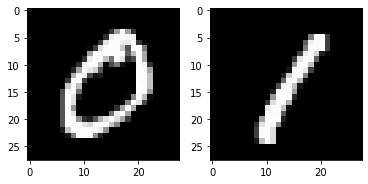

In [3]:
# show examples
fig,axs = plt.subplots(1,2)
axs[0].imshow(train_dataset[0][0].reshape(28, 28),cmap='gray')
axs[1].imshow(train_dataset[1][0].reshape(28, 28),cmap='gray')

In [4]:
batch_size = 256
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=4)

# Train VAE

## Initilize the model

In [5]:
# model
input_dim = train_dataset[0][0].shape[-1]  # The dimension of the data
hidden_dims = [64, 32]  # The dimension of the hidden layers
latent_dim = 2  # The latent space dimension
hidden_activation = nn.Tanh()  # The activation function of the hidden layers
encoder_output_mu_activation = nn.Identity() # Activation of the output of mu by the encoder
encoder_output_logvar_activation = nn.Softplus() # Activation of the output of logvar by the encoder
decoder_output_mu_activation = nn.Sigmoid() # Activation of the output of mu by the decoder
decoder_output_logvar_activation = nn.Softplus() # Activation of the output of logvar by the decoder

# optimizer
lambda_reg = 1e-7 # weight decay (l2 regulariztaion to the losss)
learning_rate = 1e-4 #1e-3

# training
epochs = 500
warmup = int(0.33 * epochs)
batch_size = 256 #128

In [6]:
# initilize model
model = VAE.VAE(input_dim, 
                hidden_dims, 
                latent_dim, 
                hidden_activation, 
                encoder_output_mu_activation,
                encoder_output_logvar_activation,
                decoder_output_mu_activation,
                decoder_output_logvar_activation)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_reg)
print(model)

VAE(
  (encoder): VAE_encoder(
    (layers): Sequential(
      (0): Linear(in_features=784, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=32, bias=True)
      (3): Tanh()
    )
    (output_mu): Sequential(
      (0): Linear(in_features=32, out_features=2, bias=True)
      (1): Identity()
    )
    (output_logvar): Sequential(
      (0): Linear(in_features=32, out_features=2, bias=True)
      (1): Softplus(beta=1, threshold=20)
    )
  )
  (decoder): VAE_decoder(
    (layers): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=64, bias=True)
      (3): Tanh()
    )
    (output_mu): Sequential(
      (0): Linear(in_features=64, out_features=784, bias=True)
      (1): Sigmoid()
    )
    (output_logvar): Sequential(
      (0): Linear(in_features=64, out_features=784, bias=True)
      (1): Softplus(beta=1, threshold=20)
    )
  )
)


## Training

[Epoch: 0/500] [objective loss: 312.211]
[Epoch: 20/500] [objective loss: 34.334]
[Epoch: 40/500] [objective loss: 28.935]
[Epoch: 60/500] [objective loss: 27.807]
[Epoch: 80/500] [objective loss: 27.444]
[Epoch: 100/500] [objective loss: 26.524]
[Epoch: 120/500] [objective loss: 25.775]
[Epoch: 140/500] [objective loss: 24.972]
[Epoch: 160/500] [objective loss: 20.976]
[Epoch: 180/500] [objective loss: 20.868]
[Epoch: 200/500] [objective loss: 20.787]
[Epoch: 220/500] [objective loss: 20.794]
[Epoch: 240/500] [objective loss: 20.747]
[Epoch: 260/500] [objective loss: 20.482]
[Epoch: 280/500] [objective loss: 20.141]
[Epoch: 300/500] [objective loss: 19.857]
[Epoch: 320/500] [objective loss: 19.733]
[Epoch: 340/500] [objective loss: 19.665]
[Epoch: 360/500] [objective loss: 19.611]
[Epoch: 380/500] [objective loss: 19.511]
[Epoch: 400/500] [objective loss: 19.177]
[Epoch: 420/500] [objective loss: 19.046]
[Epoch: 440/500] [objective loss: 18.892]
[Epoch: 460/500] [objective loss: 18.88

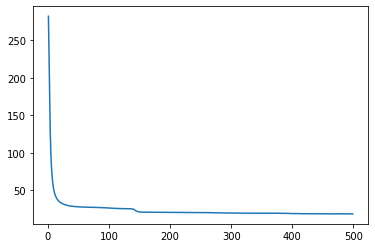

In [7]:
# Train the VAE with the new prior
ELBO_loss = []
for epoch in range(epochs):
    # Initialize the losses
    train_loss = 0.0

    for X_batch,y_batch in train_loader:
        # Forward pass
        MU_X_eval, LOG_VAR_X_eval, Z_ENC_eval, MU_Z_eval, LOG_VAR_Z_eval = model(X_batch)

        # Compute the regluarization parameter for the warmup
        # that forces the latent variables to follow the prior distribution
        # see the code of VAE_loss for more informations
        r = min(1.0, epoch / warmup) if warmup > 0 else 0.0 

        # The VAE loss
        loss = VAE.VAE_loss(x=X_batch, mu_x=MU_X_eval, log_var_x=LOG_VAR_X_eval,
                                        mu_z=MU_Z_eval, log_var_z=LOG_VAR_Z_eval, r=r)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Average loss for the epoch
    average_epoch_loss = train_loss / len(train_loader)
    ELBO_loss.append(average_epoch_loss)

    if epoch % 20 == 0:
        print(f"[Epoch: {epoch}/{epochs}] [objective loss: {average_epoch_loss:.3f}]")
    
ELBO_train = round(ELBO_loss[-1], 2)
print(f'[ELBO train: {ELBO_train}]')
print("Training finished")

plt.figure()
plt.plot(range(1, epochs), ELBO_loss[1:])
# plt.xlabel('Epochs')
# plt.ylabel('ELBO Loss')
plt.show()

## Plot the latent space

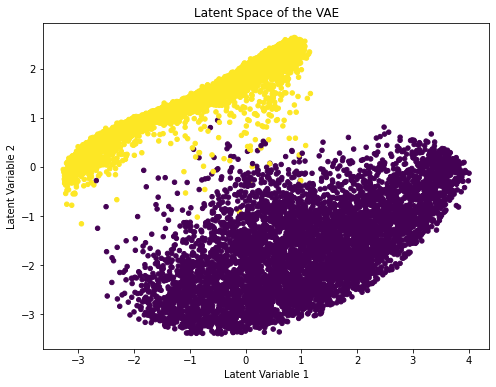

In [9]:
model.eval()

# Create lists to store the outputs and labels
latent_means_list = []
latent_logvars_list = []
latent_z = []
labels_list = []

with torch.no_grad():  
    for imgs, labels in train_loader: 
        mu, log_var = model.encode(imgs)  
        z_rep = VAE.VAE.reparametrization_trick(mu, log_var)
        latent_z.append(z_rep)
        latent_means_list.append(mu)
        latent_logvars_list.append(log_var)

        labels_list.append(labels)

# Now we concatenate the list to form a single Tensor
latent_means = torch.cat(latent_means_list, dim=0)
latent_logvars = torch.cat(latent_logvars_list, dim=0)
latent_z = torch.cat(latent_z, dim=0)
labels = torch.cat(labels_list, dim=0)


# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(latent_means[:, 0], latent_means[:, 1], c=labels, s=20)
plt.xlabel('Latent Variable 1')
plt.ylabel('Latent Variable 2')
plt.title('Latent Space of the VAE')
plt.show()

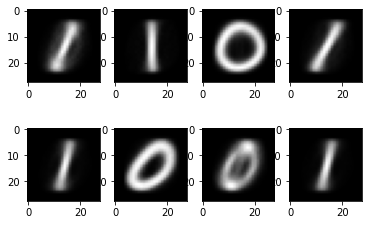

In [10]:
# display reconstructed output of the model
fig,axs = plt.subplots(2,4)
with torch.no_grad():
    for i in range(8):
        random_index = np.random.randint(0, len(train_dataset))
        pred = model(train_dataset[random_index][0].unsqueeze(0))[0] #just get mu_x
        axs[i//4,i%4].imshow(pred.reshape(28, 28),cmap='gray')

In [13]:
torch.save(model.state_dict(), 'torch_models/VAE_model_vanilla.pt')